In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0)

## Optimization model

In [3]:
tsp_model = spo.model.tspModel(m)

Academic license - for non-commercial use only - expires 2021-10-08
Using license file C:\Users\Apocrypse\gurobi.lic


In [4]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print('Obj: {}'.format(obj))
tour = tsp_model.getTour(sol)
print(' -> '.join(map(str, tour)))

Obj: 105.82300000000001
0 -> 2 -> 14 -> 6 -> 18 -> 5 -> 10 -> 9 -> 1 -> 4 -> 7 -> 19 -> 11 -> 8 -> 12 -> 3 -> 17 -> 15 -> 16 -> 13 -> 0


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
tsp_dataset_train = spo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.67it/s]


In [8]:
# get test data set
tsp_dataset_test = spo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.08it/s]


In [9]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 10])

In [12]:
c.shape

torch.Size([32, 190])

In [13]:
w.shape

torch.Size([32, 190])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, tsp_model)

In [18]:
# training
twostage_model.fit(tsp_dataset_train.x, tsp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.c[i]
    z_true_i = tsp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(tsp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(tsp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.48it/s]


Normalized true SPO Loss: 8.25%
Normalized unambiguous SPO Loss: 8.25%


In [21]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 13.25, 4.86, 8.45, 10.37, 11.59, 7.92, 11.79, 9.19, 31.81, 14.29, 15.88, 18.52, 4.62, 9.18, 12.49, 3.04, 5.85, 13.22, 5.49, 19.30, 9.96, 3.84, 9.55, 10.27, 10.12, 13.34, 3.58, 19.97, 12.15, 10.98, 14.39, 8.80, 6.37, 9.62, 5.41, 24.63, 6.22, 10.21, 16.54, 5.43, 4.92, 15.74, 11.16, 11.72, 8.56, 4.76, 9.56, 5.97, 6.99, 26.69, 12.31, 8.39, 8.14, 7.51, 19.35, 35.81, 13.44, 15.61, 15.96, 18.10, 12.31, 7.08, 8.60, 8.21, 12.19, 8.99, 6.85, 5.14, 15.12, 25.72, 19.09, 12.86, 8.26, 15.34, 4.74, 8.27, 15.21, 11.81, 11.34, 8.86, 13.00, 12.24, 9.96, 11.69, 7.03, 3.55, 7.19, 11.21, 9.27, 5.41, 8.63, 22.09, 8.56, 6.08, 14.82, 8.14, 12.44, 6.30, 6.68, 7.42, 18.44, 13.47, 3.02, 9.94, 11.70, 6.12, 5.52, 6.81, 13.11, 22.28, 3.60, 8.69, 20.46, 6.85, 8.35, 11.98, 14.46, 10.66, 17.24, 13.49, 17.29, 10.72, 8.30, 19.77, 14.82, 10.57, 7.58, 3.31, 8.00, 9.19, 7.16, 8.48, 5.51, 13.26, 8.63, 7.08, 11.09, 20.63, 10.96, 16.02, 5.98, 6.98, 7.15, 9.08, 6.95, 7.20, 11.16, 7.63, 9.35, 6.53, 3.10

    True sol: 0 -> 2 -> 5 -> 10 -> 18 -> 6 -> 9 -> 4 -> 1 -> 7 -> 14 -> 19 -> 13 -> 11 -> 12 -> 3 -> 8 -> 17 -> 15 -> 16 -> 0, True obj: 96.45
    True sol: 0 -> 8 -> 12 -> 3 -> 1 -> 4 -> 9 -> 19 -> 14 -> 7 -> 2 -> 5 -> 10 -> 18 -> 6 -> 11 -> 13 -> 17 -> 15 -> 16 -> 0, True obj: 100.37



## Linear Regression from PyTorch 

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus(tsp_model, processes=4)

Num of cores: 4


In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:9.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:   92.9656, True SPO Loss: 12.3821%, Unambiguous SPO Loss: 12.3821%
Epoch  20, Loss:   35.9559, True SPO Loss:  6.5986%, Unambiguous SPO Loss:  6.5986%
Epoch  30, Loss:   39.3817, True SPO Loss:  4.6057%, Unambiguous SPO Loss:  4.6057%
Epoch  40, Loss:   15.1363, True SPO Loss:  3.7069%, Unambiguous SPO Loss:  3.7069%
Epoch  50, Loss:   42.7438, True SPO Loss:  3.2709%, Unambiguous SPO Loss:  3.2709%
Epoch  60, Loss:   11.1143, True SPO Loss:  2.7596%, Unambiguous SPO Loss:  2.7596%
Epoch  70, Loss:   27.1011, True SPO Loss:  2.5705%, Unambiguous SPO Loss:  2.5705%
Epoch  80, Loss:   14.5927, True SPO Loss:  2.4641%, Unambiguous SPO Loss:  2.4641%
Epoch  90, Loss:   17.2522, True SPO Loss:  2.3695%, Unambiguous SPO Loss:  2.3695%
Epoch 100, Loss:   10.8221, True SPO Loss:  2.2155%, Unambiguous SPO Loss:  2.2155%
Epoch 110, Loss:   17.1722, True SPO Loss:  2.0441%, Unambiguous SPO Loss:  2.0441%
Epoch 120, Loss:   15.6238, True SPO Loss:  1.9618%, Unambiguous SPO Loss:  

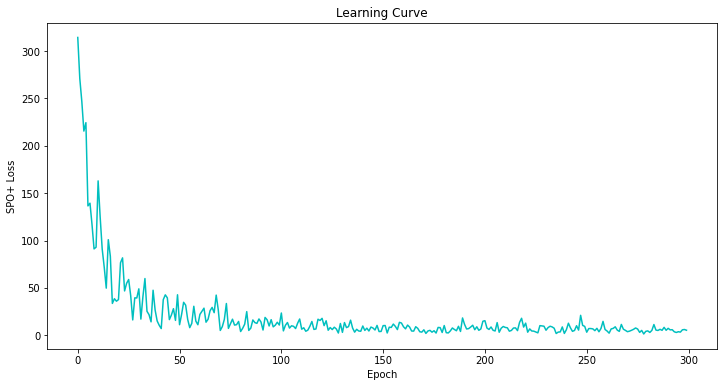

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

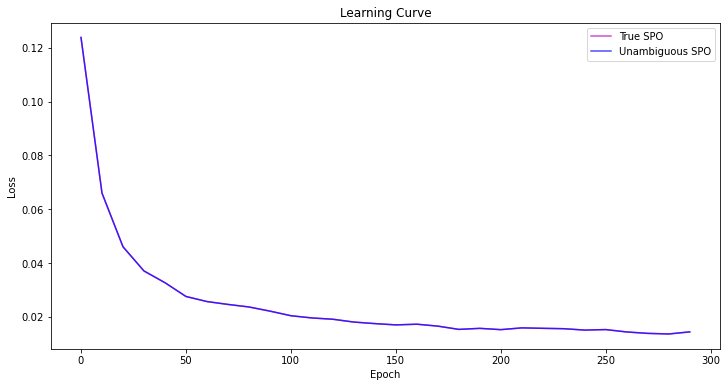

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.44%
Normalized unambiguous SPO Loss: 1.44%


In [31]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 13.25, 4.86, 8.45, 10.37, 11.59, 7.92, 11.79, 9.19, 31.81, 14.29, 15.88, 18.52, 4.62, 9.18, 12.49, 3.04, 5.85, 13.22, 5.49, 19.30, 9.96, 3.84, 9.55, 10.27, 10.12, 13.34, 3.58, 19.97, 12.15, 10.98, 14.39, 8.80, 6.37, 9.62, 5.41, 24.63, 6.22, 10.21, 16.54, 5.43, 4.92, 15.74, 11.16, 11.72, 8.56, 4.76, 9.56, 5.97, 6.99, 26.69, 12.31, 8.39, 8.14, 7.51, 19.35, 35.81, 13.44, 15.61, 15.96, 18.10, 12.31, 7.08, 8.60, 8.21, 12.19, 8.99, 6.85, 5.14, 15.12, 25.72, 19.09, 12.86, 8.26, 15.34, 4.74, 8.27, 15.21, 11.81, 11.34, 8.86, 13.00, 12.24, 9.96, 11.69, 7.03, 3.55, 7.19, 11.21, 9.27, 5.41, 8.63, 22.09, 8.56, 6.08, 14.82, 8.14, 12.44, 6.30, 6.68, 7.42, 18.44, 13.47, 3.02, 9.94, 11.70, 6.12, 5.52, 6.81, 13.11, 22.28, 3.60, 8.69, 20.46, 6.85, 8.35, 11.98, 14.46, 10.66, 17.24, 13.49, 17.29, 10.72, 8.30, 19.77, 14.82, 10.57, 7.58, 3.31, 8.00, 9.19, 7.16, 8.48, 5.51, 13.26, 8.63, 7.08, 11.09, 20.63, 10.96, 16.02, 5.98, 6.98, 7.15, 9.08, 6.95, 7.20, 11.16, 7.63, 9.35, 6.53, 3.10

    True sol: 0 -> 2 -> 18 -> 5 -> 6 -> 10 -> 15 -> 1 -> 9 -> 7 -> 4 -> 3 -> 17 -> 12 -> 8 -> 13 -> 14 -> 16 -> 11 -> 19 -> 0, True obj: 87.89

Sample 4:
    True cost: 8.82, 3.82, 9.29, 12.19, 6.99, 12.28, 16.81, 7.59, 9.99, 4.64, 4.17, 8.22, 5.57, 7.44, 5.98, 4.60, 6.76, 14.80, 17.29, 11.54, 6.83, 4.21, 12.41, 13.05, 6.06, 13.23, 2.56, 6.69, 9.66, 12.92, 9.11, 10.33, 7.25, 7.27, 8.62, 13.00, 16.79, 15.79, 14.24, 7.52, 6.81, 13.42, 14.02, 16.45, 13.65, 6.40, 10.96, 10.80, 7.59, 9.68, 6.57, 10.77, 17.10, 9.07, 10.25, 17.66, 15.95, 25.91, 7.11, 6.91, 13.66, 12.80, 7.46, 6.33, 12.11, 4.33, 8.92, 5.06, 14.00, 7.27, 14.13, 12.19, 14.15, 19.26, 2.41, 14.60, 10.84, 13.49, 12.83, 10.71, 18.18, 10.30, 14.25, 21.80, 7.53, 3.76, 8.40, 15.18, 13.56, 5.02, 6.90, 12.49, 13.03, 3.59, 8.24, 5.49, 15.29, 6.12, 9.57, 10.66, 11.93, 8.42, 3.56, 4.98, 14.77, 8.20, 7.71, 8.39, 10.28, 8.80, 4.24, 9.22, 14.56, 4.06, 10.34, 8.05, 12.42, 9.47, 6.29, 8.82, 7.37, 19.93, 10.47, 14.98, 12.15, 26.62, 12.87, 6.05, 1

    True sol: 0 -> 11 -> 13 -> 15 -> 16 -> 19 -> 7 -> 9 -> 4 -> 1 -> 3 -> 17 -> 12 -> 8 -> 2 -> 10 -> 18 -> 5 -> 6 -> 14 -> 0, True obj: 99.01
    True sol: 0 -> 11 -> 13 -> 15 -> 16 -> 19 -> 7 -> 4 -> 9 -> 1 -> 3 -> 17 -> 12 -> 8 -> 2 -> 10 -> 18 -> 5 -> 6 -> 14 -> 0, True obj: 102.28

Sample 8:
    True cost: 15.15, 3.78, 10.09, 21.78, 13.86, 9.09, 11.39, 8.89, 10.91, 5.46, 12.49, 7.76, 11.92, 18.80, 6.74, 2.90, 23.61, 6.37, 4.64, 13.37, 5.80, 4.99, 10.90, 17.11, 23.81, 12.37, 3.87, 6.74, 12.01, 18.09, 10.48, 13.13, 8.64, 9.58, 6.30, 13.38, 6.82, 27.18, 14.95, 8.39, 17.88, 15.64, 8.44, 38.80, 10.86, 12.85, 9.02, 12.17, 6.85, 7.03, 6.10, 11.96, 8.75, 8.86, 7.58, 22.23, 14.07, 9.95, 6.79, 6.34, 14.57, 21.31, 8.75, 6.18, 20.73, 4.24, 7.63, 4.96, 12.55, 7.16, 11.24, 10.09, 6.79, 28.05, 2.87, 10.25, 9.25, 18.98, 12.11, 10.27, 9.63, 14.51, 16.28, 11.65, 11.87, 1.36, 13.26, 13.11, 12.85, 14.45, 7.75, 24.22, 9.86, 3.93, 23.00, 5.27, 9.49, 6.16, 7.81, 13.22, 16.55, 8.31, 3.62, 6.21, 13.53, 11